In [186]:
#project 5
import pandas as pd
import os
import seaborn as sns
#import sqlite
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_curve, auc

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

In [2]:
pwd

u'/Users/marthataylor/week03_classwork'

In [3]:
titanic= pd.read_csv('~/titanic.csv')

April 1912, the Titanic sank after scraping an iceberg on its maiden journey. A very sad story since many people perished. There were design flaws and there were not enough life boats. If each boat was filled they could only accommodate 1,178 people.


891 records This does not represent the total number of people on the Titanic. Passengers = 1317 and with crew = 2224.  more than 1500 died

This list contains 891 records

Survival 0 1
pClass   passenger class

name

sex
age  Age there are only 714
sibsp   number of siblings/spouses aboard
parch   number of parents/children aboard
ticket  ticket number
fare    passenger fare
cabin   cabin  Cabin assignments  there are only 204
embarked  point of embarkation  (C=Cherbourg, Q Queenstown, S Southampton Embarking location = 889

There are only 204 cabins


In [4]:
#systematically describe  each variable to identify datatype and to see
#how many are null
tColumms = []
i=0
for labels in titanic.columns:  
    if i >=0:
        tColumms.append(labels)
        i = i+1
    else:
        i=i+1

for item in tColumms:
    print 'For %s' %item
    print titanic[item].isnull().sum()
    print titanic[item].describe()
    print ' '

For index
0
count    891.000000
mean     445.000000
std      257.353842
min        0.000000
25%      222.500000
50%      445.000000
75%      667.500000
max      890.000000
Name: index, dtype: float64
 
For PassengerId
0
count    891.000000
mean     446.000000
std      257.353842
min        1.000000
25%      223.500000
50%      446.000000
75%      668.500000
max      891.000000
Name: PassengerId, dtype: float64
 
For Survived
0
count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64
 
For Pclass
0
count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64
 
For Name
0
count                           891
unique                          891
top       Graham, Mr. George Edward
freq                              1
Name: Name, dtype

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [331]:
titanic.columns


Index([u'index', u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex',
       u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'first', u'second', u'third', u'embarked_C', u'embarked_Q', u'Child',
       u'Older Person', u'Male', u'unknownAge', u'AgeFilledIn',
       u'unknownCabin'],
      dtype='object')

# Create Dummies

In [6]:
#create dummies and then do exploratiory analysis

In [7]:
#create dummies for pclass which is the socio economic class of the passengers
#it is not whether they purchsed a first second or third class ticket
dummiesPclass=pd.get_dummies(titanic['Pclass'])
titanic=pd.DataFrame(titanic).join(pd.DataFrame(dummiesPclass))

In [8]:
titanic.columns=['index', 'PassengerId', 'Survived', 'Pclass',
              'Name',  'Sex', 'Age','SibSp','Parch','Ticket', 'Fare',  'Cabin',
'Embarked', 'first','second',  'third']

In [9]:
#categorizing gender (only 2 Male Female)
male = titanic['Sex'].apply(lambda x: 1 if x == 'male' else 0)
male.head(2)

0    1
1    0
Name: Sex, dtype: int64

In [10]:
#categorizing where the passenger embarked
embarkedDummies = pd.get_dummies(titanic['Embarked'], prefix='embarked')
embarkedDummies = embarkedDummies[['embarked_C', 'embarked_Q']]
embarkedDummies.head(1)

,embarked_C,embarked_Q
0,0.0,0.0


In [11]:
#joining the main database embarked dummies
titanic=titanic.join(embarkedDummies)

In [12]:
#categorizing age by groupings child, adult, older person
titanic['Child'] = titanic['Age'].apply(lambda x: 1 if x < 12 else 0)
titanic['Older Person'] = titanic['Age'].apply(lambda x: 1 if x > 50 else 0)




In [13]:
#titanic['Male']=titanic['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [14]:
#creating an if known age column.  Missing age = 0
titanic['unknownAge']=titanic['Age']
titanic['unknownAge'].fillna('Missing', inplace=True)
titanic['unknownAge'] = titanic['unknownAge'].apply(lambda x: 1 if x =='Missing' else 0)

In [15]:
titanic[['Age', 'unknownAge']].head(2)

,Age,unknownAge
0,22.0,0
1,38.0,0


In [16]:
#for the age column, filling in the NaN with the average age
print titanic['Age'].describe()
ageMean = np.mean(titanic['Age'])


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%             NaN
50%             NaN
75%             NaN
max       80.000000
Name: Age, dtype: float64


In [17]:
#My goal is to keep all but to entries (embarkment) when doing the drop NaN
#I am going to insert the mean 
titanic['AgeFilledIn']=titanic['Age']
titanic['AgeFilledIn'].fillna(ageMean, inplace=True)
#titanic['AgeFilledIn'] = titanic['AgeFilledIn'].apply(lambda x: ageMean if x =='Missing')
titanic[['Age', 'AgeFilledIn']].head(6)

,Age,AgeFilledIn
0,22.0,22.000000
1,38.0,38.000000
2,26.0,26.000000
3,35.0,35.000000
4,35.0,35.000000
5,NaN,29.699118


In [18]:
#creating an unknown cabin category. Perhaps those who did not have a cabin assignment
# were not worthy of having one assigned prior to departure
titanic['unknownCabin']=titanic['Cabin']
titanic['unknownCabin'].fillna('Missing', inplace=True)
titanic['unknownCabin'] = titanic['unknownCabin'].apply(lambda x: 1 if x =='Missing' else 0)
titanic[['Cabin', 'unknownCabin']].head(10)

,Cabin,unknownCabin
0,NaN,1
1,C85,0
2,NaN,1
3,C123,0
4,NaN,1
5,NaN,1
6,E46,0
7,NaN,1
8,NaN,1
9,NaN,1


# now starting with playing with variables prior to building models
I created df1 a dataframe with only the variables I will be testing.
I am going to explore some of the data


In [19]:
titanic.columns

Index([u'index', u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex',
       u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'first', u'second', u'third', u'embarked_C', u'embarked_Q', u'Child',
       u'Older Person', u'Male', u'unknownAge', u'AgeFilledIn',
       u'unknownCabin'],
      dtype='object')

Exploring the relationships prior to starting my models

In [237]:
df1= titanic[['Survived','AgeFilledIn','Age', 'SibSp', 'Parch','Fare','first', 'second', 'third', 'embarked_C', 
              'embarked_Q', 'Child', 'Older Person', 'Male', 'unknownAge',
           'unknownCabin']]
df1.head(10)

,Survived,AgeFilledIn,Age,SibSp,Parch,Fare,first,second,third,embarked_C,embarked_Q,Child,Older Person,Male,unknownAge,unknownCabin
0,0,22.000000,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,0.0,0,0,1,0,1
1,1,38.000000,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,0,0,0,0,0
2,1,26.000000,26.0,0,0,7.9250,0.0,0.0,1.0,0.0,0.0,0,0,0,0,1
3,1,35.000000,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0
4,0,35.000000,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,0.0,0,0,1,0,1
5,0,29.699118,NaN,0,0,8.4583,0.0,0.0,1.0,0.0,1.0,0,0,1,1,1
6,0,54.000000,54.0,0,0,51.8625,1.0,0.0,0.0,0.0,0.0,0,1,1,0,0
7,0,2.000000,2.0,3,1,21.0750,0.0,0.0,1.0,0.0,0.0,1,0,1,0,1
8,1,27.000000,27.0,0,2,11.1333,0.0,0.0,1.0,0.0,0.0,0,0,0,0,1
9,1,14.000000,14.0,1,0,30.0708,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1


In [238]:
#correlation matrix
corr=df1.corr()
corr

,Survived,AgeFilledIn,Age,SibSp,Parch,Fare,first,second,third,embarked_C,embarked_Q,Child,Older Person,Male,unknownAge,unknownCabin
Survived,1.000000,-6.980852e-02,-0.077221,-0.035322,0.081629,0.257307,0.285904,0.093349,-0.322308,0.168240,0.003650,0.112119,-0.022932,-0.543351,-9.219652e-02,-0.316912
AgeFilledIn,-0.069809,1.000000e+00,1.000000,-0.232625,-0.179191,0.091566,0.319916,0.006589,-0.281004,0.032024,-0.013855,-0.553774,0.621244,0.084153,-1.465772e-16,-0.233123
Age,-0.077221,1.000000e+00,1.000000,-0.308247,-0.189119,0.096067,0.348941,0.006954,-0.312271,0.036261,-0.022405,-0.559534,0.627290,0.093254,NaN,-0.249732
SibSp,-0.035322,-2.326246e-01,-0.308247,1.000000,0.414838,0.159651,-0.054582,-0.055932,0.092548,-0.059528,-0.026354,0.354531,-0.068910,-0.114631,1.895757e-02,0.040460
Parch,0.081629,-1.791909e-01,-0.189119,0.414838,1.000000,0.216225,-0.017633,-0.000734,0.015790,-0.011069,-0.081228,0.372819,-0.029255,-0.245489,-1.241038e-01,-0.036987
Fare,0.257307,9.156609e-02,0.096067,0.159651,0.216225,1.000000,0.591711,-0.118557,-0.413333,0.269335,-0.117216,-0.002138,0.063857,-0.182333,-1.007071e-01,-0.482075
first,0.285904,3.199164e-01,0.348941,-0.054582,-0.017633,0.591711,1.000000,-0.288585,-0.626738,0.296423,-0.155342,-0.123148,0.238201,-0.098013,-8.473423e-02,-0.788773
second,0.093349,6.589145e-03,0.006954,-0.055932,-0.000734,-0.118557,-0.288585,1.000000,-0.565210,-0.125416,-0.127301,0.030882,0.019150,-0.064746,-1.775626e-01,0.172413
third,-0.322308,-2.810040e-01,-0.312271,0.092548,0.015790,-0.413333,-0.626738,-0.565210,1.000000,-0.153329,0.237449,0.080971,-0.220820,0.137143,2.175179e-01,0.539291
embarked_C,0.168240,3.202442e-02,0.036261,-0.059528,-0.011069,0.269335,0.296423,-0.125416,-0.153329,1.000000,-0.148258,-0.030492,0.032589,-0.082853,3.326967e-02,-0.208528


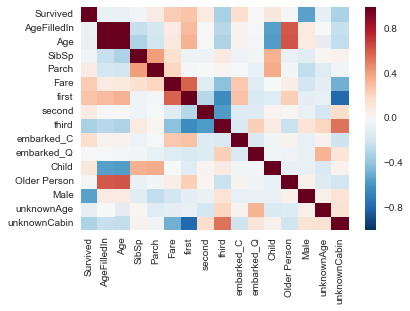

In [382]:
#created heat map to get visual of relationships
sns.heatmap(corr, annot=True)

In [240]:
#using the original table
print titanic.pivot_table(index='Sex',values='Fare',aggfunc=np.mean)

Sex
female    44.479818
male      25.523893
Name: Fare, dtype: float64


In [241]:
titanic.pivot_table( index='Embarked', values=["Pclass"],aggfunc=len)

,Pclass
Embarked,
C,168
Q,77
S,644


In [242]:
byClasscount=pd.pivot_table(titanic, index='Pclass', values = ['PassengerId'],aggfunc=len)
byClasscount.reset_index(inplace = True)
byClasscount
#byClasscount=byClasscount.set_index('Pclass', inplace=True)

,Pclass,PassengerId
0,1,216
1,2,184
2,3,491


In [243]:
survivedCt= titanic[(titanic["Survived"]==1)]
survivedCt.head(1)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,first,second,third,embarked_C,embarked_Q,Child,Older Person,Male,unknownAge,AgeFilledIn,unknownCabin
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,0.0,1.0,0.0,0,0,0,0,38.0,0


In [244]:
survivedByClass=pd.pivot_table(survivedCt, index=['Pclass'], values=['Survived'], aggfunc=len)
survivedByClass.reset_index(inplace=True)

In [245]:

#pd.merge?
survivedByClass.join(byClasscount, lsuffix='_l')

,Pclass_l,Survived,Pclass,PassengerId
0,1,136,1,216
1,2,87,2,184
2,3,119,3,491


In [246]:
survivedByClass.reset_index(inplace=True)
survivedByClass.columns
survivedByClass.head()


,index,Pclass,Survived
0,0,1,136
1,1,2,87
2,2,3,119


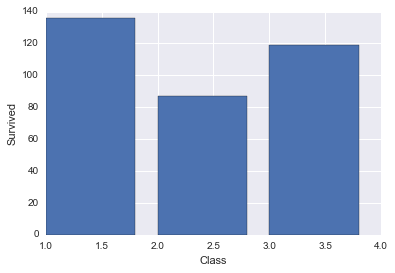

In [247]:
plt.bar(survivedByClass['Pclass'], survivedByClass['Survived'])
plt.xlabel("Class")
plt.ylabel('Survived');



49.66553444477411

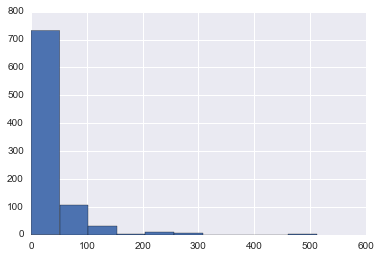

In [248]:
plt.hist(titanic['Fare']);
np.std(titanic['Fare'])

In [249]:
fareRangeByClass= titanic.pivot_table(index='Pclass',values='Fare',aggfunc=[np.min, np.max])
fareRangeByClass

,amin,amax
Pclass,,
1,0.0,512.3292
2,0.0,73.5000
3,0.0,69.5500


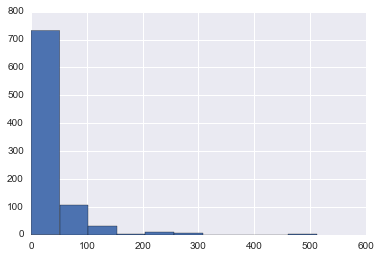

In [250]:
np.std(titanic['Fare'])
plt.hist(titanic['Fare']);


In [343]:
classToUnknownAge= titanic.pivot_table(index='Pclass',values='unknownAge',aggfunc=[np.sum])
classToUnknownAge.reset_index(inplace=True)
print classToUnknownAge.columns


Index([u'Pclass', u'sum'], dtype='object')


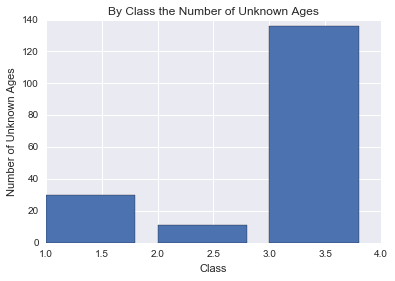

In [347]:
plt.bar(classToUnknownAge['Pclass'], classToUnknownAge['sum'])
plt.title('By Class the Number of Unknown Ages')
plt.xlabel("Class")
plt.ylabel('Number of Unknown Ages');

In [349]:
classToUnknownCabin= titanic.pivot_table(index='Pclass',values='unknownCabin',aggfunc=[np.sum])
classToUnknownCabin.reset_index(inplace=True)
print classToUnknownCabin.columns

Index([u'Pclass', u'sum'], dtype='object')


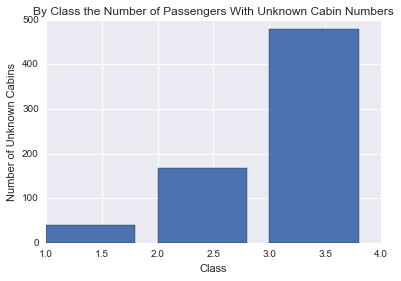

In [351]:
plt.bar(classToUnknownCabin['Pclass'], classToUnknownCabin['sum'])
plt.title('By Class the Number of Passengers With Unknown Cabin Numbers')
plt.xlabel("Class")
plt.ylabel('Number of Unknown Cabins');

# beginning to test variables

In [251]:
#dropping duplicates 
#This is why I created df1. I did not want the cabin number to be included. If it was I would 
#be dropping too many rows.
#also I added the mean of ages to the missing data from the age row. 

In [35]:
print df1.shape
df1.dropna(inplace=True)
print df1.shape
#Because I filled in all those travelers without age with the mean of age then there were 
#no drops


(891, 15)
(891, 15)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Getting dataset finalized and dividing the data into train test


In [255]:
#defining X and y and checking their shape
y=df1['Survived']
X=df1[['AgeFilledIn',  'SibSp', 'Parch', 'Fare', 'first', 'second',
       'third', 'embarked_C', 'embarked_Q', 'Child', 'Older Person',
       'Male', 'unknownAge', 'unknownCabin']]
print y.shape
print X.shape

(891,)
(891, 14)


In [381]:
#Model - KNneighbors
#looking at the 5 closest through KNeighbors  I tried 3 and 5  and 7 on ALL data 
#using cross_val went through and created 10 folds. More accurate than TTS 
#This score was not as good as doing a logistic regression (see below)
#


# neigh = KNeighborsClassifier(n_neighbors=5)
# print X.shape, y.shape
# #neigh.fit(X.reshape(-1, 1),y.reshape(-1,1))
# neigh.fit(x_train,y_train)
# #print neigh.predict([[0]])
# y_predict=neigh.predict(x_test)
# print metrics.accuracy_score(y_test, y_predict)

#cross_val does the spliting for you so you do not need to do the above

neigh = KNeighborsClassifier(n_neighbors=7)
scores=cross_val_score(neigh, X,y,  cv=5, scoring ='accuracy')
print scores
print scores.mean()

[ 0.63687151  0.69273743  0.71910112  0.75280899  0.74011299]
0.708326409051


# Logistic regressions 
The model is Logistic Regression with 3 differnt datasets.
1. My guess used the TTS and Lasso and Ridge, show the confusion table and ROC
2. All top down  then I looked at  GridCV 
3. Kbest then I looked at  GridCV


In [353]:
#creating train and test dataframes.  I select test size of .4, therefore
#the train size will be .6
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size =.4)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((534, 14), (357, 14), (534,), (357,))

In [354]:
# Model 1 MyGuess with the variables I think will predict survival
#I used the correlation table for guidance
#This is TTS

x_trainMyGuess=x_train[['first','Fare', 'third','unknownCabin', 'Male']]
x_testMyGuess=x_test[['first','Fare', 'third','unknownCabin', 'Male']]
modelMyGuess = LogisticRegression() 
modelMyGuess.fit(x_trainMyGuess, y_train) 
Y_pred = modelMyGuess.predict(x_testMyGuess)
modelMyGuess.score(x_trainMyGuess, y_train)

0.7808988764044944

In [355]:
#now using the test data in my prediction model.
#it is close but the training the model with training data did very slightly
# overfit the data

modelMyGuess.fit(x_testMyGuess, y_test) 
modelMyGuess.score(x_testMyGuess, y_test)


0.78991596638655459

In [356]:
#running all the data through the model.

modelMyGuess.fit(X, y) 
modelMyGuess.score(X, y)

0.81144781144781142

In [357]:
#look at the confusion matric
#My model predicted (179+99) correctly and (40 + 39) incorrectly
#with approximately .78 accuracy the model will predict whether a passenger would survive 
#given the following variables: 'first','Fare', 'third','unknownCabin', 'Male'
#
conmat = np.array(confusion_matrix(y_test, Y_pred))

confusion = pd.DataFrame(conmat, index=['Survived', 'Did not survived'],
                         columns=['Predicted Survived', 'Predicted Did Not Survived'])

print(confusion)

                  Predicted Survived  Predicted Did Not Survived
Survived                         182                          42
Did not survived                  36                          97


In [358]:
#Precision is tp/(tp + fp)  is the probabliy that some predicted to not survive actual 
#does not survive
#recall = tp/(tp + fn)  that someone who predicted to survive 
#is labeled as such

cls_rep = classification_report(y_test, Y_pred)
print(cls_rep)

             precision    recall  f1-score   support

          0       0.83      0.81      0.82       224
          1       0.70      0.73      0.71       133

avg / total       0.78      0.78      0.78       357



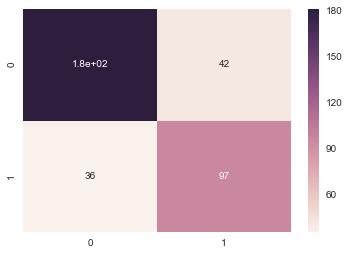

In [361]:
sns.heatmap(confusion_matrix(y_test, Y_pred), annot=True)

In [264]:
TP = confusion.ix['Did not survived', 'Predicted Did Not Survived']
FP = confusion.ix['Survived', 'Predicted Did Not Survived']
TN = confusion.ix['Survived', 'Predicted Survived']
FN = confusion.ix['Did not survived', 'Predicted Survived']

print(zip(['True Positives','False Positives','True Negatives','False Negatives'],
          [TP, FP, TN, FN]))

[('True Positives', 96), ('False Positives', 37), ('True Negatives', 178), ('False Negatives', 46)]


In [294]:
#Applying lasso when regularizing will zero out some of the coefficients (variables)
#the goal is to not have a model that overfits the data
#Overfitting will not allow the model to be used for a different set of data
#I changed the value of C to see how that affected the model
#I settled on 10 which increased the accuracy to .81
lmMyScoresLasso=LogisticRegression(penalty='l1', C=10.0)
lmMyScoresLasso.fit(X, y)
lmMyScoresLasso.score(X,y)

0.8125701459034792

In [297]:
#Applying ridge when regularizing  the model reduces the coefficients
#I should have used lasso and ridge on my all variable model.  In this model 
#there are not alot of variables.  Changing C in this model did very little to affect
#accuracy
lmMyScoresRidge=LogisticRegression(penalty='l2', C=0.1)
lmMyScoresRidge.fit(X, y)
print lmMyScoresRidge.score(X,y)

0.811447811448


In [298]:
#ROC
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)

In [299]:
Y_score=logreg.decision_function(x_test)

In [300]:
y_score = logreg.decision_function(x_test)
FPR = dict()
TPR = dict()
ROC_AUC = dict() # {}

(array([ 0.        ,  0.        ,  0.00465116,  0.00465116,  0.00930233,
        0.00930233,  0.00930233,  0.00930233,  0.01395349,  0.01395349,
        0.01395349,  0.01395349,  0.02325581,  0.02325581,  0.03255814,
        0.03255814,  0.0372093 ,  0.0372093 ,  0.04186047,  0.04186047,
        0.04651163,  0.04651163,  0.05581395,  0.05581395,  0.06046512,
        0.06046512,  0.06511628,  0.06511628,  0.06976744,  0.06976744,
        0.06976744,  0.06976744,  0.0744186 ,  0.0744186 ,  0.07906977,
        0.07906977,  0.09302326,  0.09302326,  0.11162791,  0.11162791,
        0.11627907,  0.11627907,  0.1255814 ,  0.1255814 ,  0.14418605,
        0.14418605,  0.14883721,  0.14883721,  0.15813953,  0.15813953,
        0.17209302,  0.17209302,  0.17674419,  0.19534884,  0.19534884,
        0.2       ,  0.2       ,  0.21395349,  0.21395349,  0.22790698,
        0.22790698,  0.23255814,  0.23255814,  0.24186047,  0.24186047,
        0.25116279,  0.25116279,  0.26511628,  0.26511628,  0.2

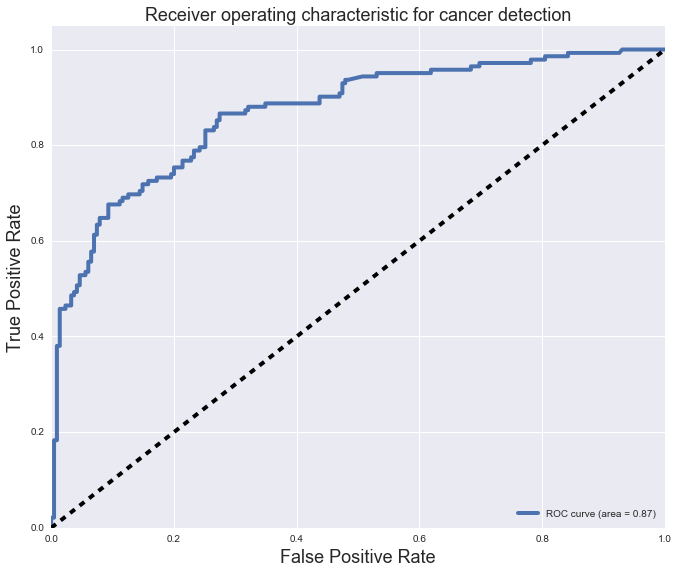

In [301]:


print roc_curve(y_test, y_score)

FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])


# Plot of a ROC curve for survived
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

nan

# Model 2 All Variables
Logistic model with all variables and using grid search cross validation 


In [362]:
#creating regress model for all
X2=df1[['SibSp','Parch', 'Fare', 'first', 'second',
       'third', 'embarked_C', 'embarked_Q', 'Child', 'Older Person',
       'Male', 'unknownAge', 'unknownCabin']]
lm2 = LogisticRegression()
lm2.fit(X2, y)
lm2.score(X2, y)

0.80471380471380471

In [363]:
#do a grid search
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 20, 50]}
model2 = LogisticRegression()

In [364]:
#
grid_search = GridSearchCV(estimator=model2,
                          param_grid=parameters,
                          verbose=10,
                          cv=6)

In [365]:
grid_search.fit(X2, y)


Fitting 6 folds for each of 10 candidates, totalling 60 fits
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.798658 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.791946 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.818792 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.783784 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.763514 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.810811 -   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:    0.2s


[CV] penalty=l1, C=10 ................................................
[CV] ....................... penalty=l1, C=10, score=0.770270 -   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ....................... penalty=l1, C=10, score=0.797297 -   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ....................... penalty=l1, C=10, score=0.837838 -   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.791946 -   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.805369 -   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.805369 -   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.770270 -   0.0s
[CV] p

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.4s


[CV] ....................... penalty=l1, C=50, score=0.805369 -   0.0s
[CV] penalty=l1, C=50 ................................................
[CV] ....................... penalty=l1, C=50, score=0.805369 -   0.0s
[CV] penalty=l1, C=50 ................................................
[CV] ....................... penalty=l1, C=50, score=0.770270 -   0.0s
[CV] penalty=l1, C=50 ................................................
[CV] ....................... penalty=l1, C=50, score=0.797297 -   0.0s
[CV] penalty=l1, C=50 ................................................
[CV] ....................... penalty=l1, C=50, score=0.837838 -   0.0s
[CV] penalty=l2, C=50 ................................................
[CV] ....................... penalty=l2, C=50, score=0.785235 -   0.0s
[CV] penalty=l2, C=50 ................................................
[CV] ....................... penalty=l2, C=50, score=0.805369 -   0.0s
[CV] penalty=l2, C=50 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.5s finished


GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [366]:
print(grid_search.best_score_)


0.801346801347


In [367]:
grid_search.best_estimator_.fit(X2, y)
#penalty = Lasso

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [368]:
grid_search.best_estimator_.score(X2, y)

0.81144781144781142

In [369]:
predictions = grid_search.best_estimator_.predict(X2)

In [370]:
X2.shape

(891, 13)

In [371]:

conM2=np.array(confusion_matrix(y, predictions))
conM2

array([[475,  74],
       [ 94, 248]])

In [374]:
conmat2 = np.array(confusion_matrix(y, predictions))

confusion = pd.DataFrame(conmat2, index=['Survived', 'Did not survived'],
                         columns=['Predicted Survived', 'Predicted Did Not Survived'])

print(confusion)
TP = confusion.ix['Did not survived', 'Predicted Did Not Survived']
FP = confusion.ix['Survived', 'Predicted Did Not Survived']
TN = confusion.ix['Survived', 'Predicted Survived']
FN = confusion.ix['Did not survived', 'Predicted Survived']



                  Predicted Survived  Predicted Did Not Survived
Survived                         475                          74
Did not survived                  94                         248


In [375]:
print classification_report(y, predictions)

             precision    recall  f1-score   support

          0       0.83      0.87      0.85       549
          1       0.77      0.73      0.75       342

avg / total       0.81      0.81      0.81       891



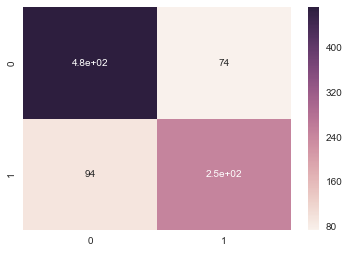

In [376]:
sns.heatmap(confusion_matrix(y, predictions), annot=True)

# KBest
#finally lets look at having KBest decide our variables

In [329]:
#checking to make sure the training and testing datashapes have not been corruped.
x_train.shape,  y_train.shape, x_test.shape, y_test.shape

((534, 14), (534,), (357, 14), (357,))

In [316]:
#now to try Kbest on ALL variables 
kbest = SelectKBest(k=5)
print kbest
results_of_kbest5 = kbest.fit_transform(x_train, y_train)
print results_of_kbest5

SelectKBest(k=5, score_func=<function f_classif at 0x116cdd9b0>)
[[ 83.475    1.       0.       1.       0.    ]
 [  8.05     0.       1.       1.       1.    ]
 [ 49.5042   1.       0.       0.       0.    ]
 ..., 
 [ 26.55     1.       0.       0.       0.    ]
 [  7.05     0.       1.       1.       1.    ]
 [ 26.55     1.       0.       1.       1.    ]]


In [317]:
print kbest.scores_
print results_of_kbest5.shape

[  2.51436900e+00   1.81558760e-01   3.58316786e+00   3.72442925e+01
   4.38010992e+01   2.00539716e+00   4.71143402e+01   1.66142237e+01
   3.17686714e-01   2.91063278e+00   1.07592215e+00   2.46204352e+02
   1.16604214e-02   4.62892714e+01]
(534, 5)


In [318]:
model_for_kbest_5_columns = LogisticRegression()
model_for_kbest_5_columns.fit(results_of_kbest5, y_train)
model_for_kbest_5_columns.score(results_of_kbest5, y_train)

0.79400749063670417

In [319]:
#running the test variables 
results_of_kbest5 = kbest.fit_transform(x_test, y_test)
model_for_kbest_5_columns = LogisticRegression()
model_for_kbest_5_columns.fit(results_of_kbest5, y_test)
model_for_kbest_5_columns.score(results_of_kbest5, y_test)

0.77591036414565828

In [320]:
#running all the variables through
results_of_kbest5 = kbest.fit_transform(X, y)
model_for_kbest_5_columns = LogisticRegression()
model_for_kbest_5_columns.fit(results_of_kbest5, y)
model_for_kbest_5_columns.score(results_of_kbest5, y)

0.78338945005611671

In [ ]:
#it appears the training model was not overfit

In [377]:



Y_predKBest = model_for_kbest_5_columns.predict(results_of_kbest5)

In [379]:
conmat3 = np.array(confusion_matrix(y, Y_predKBest))

confusion = pd.DataFrame(conmat3, index=['Survived', 'Did not survived'],
                         columns=['Predicted Survived', 'Predicted Did Not Survived'])

print(confusion)
TP = confusion.ix['Did not survived', 'Predicted Did Not Survived']
FP = confusion.ix['Survived', 'Predicted Did Not Survived']
TN = confusion.ix['Survived', 'Predicted Survived']
FN = confusion.ix['Did not survived', 'Predicted Survived']

                  Predicted Survived  Predicted Did Not Survived
Survived                         463                          86
Did not survived                 107                         235


In [380]:
cls_rep = classification_report(y, Y_predKBest)
print(cls_rep)

             precision    recall  f1-score   support

          0       0.81      0.84      0.83       549
          1       0.73      0.69      0.71       342

avg / total       0.78      0.78      0.78       891

